# Audio Event Detection: Assignment 1
### Ayushi Chaudhary [190221]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# Importing the libraries
import os
import matplotlib
import matplotlib.pyplot as plt
matplotlib inline
import pathlib
from glob import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

### Data Loading

In [ ]:
#Table of Data
loc = "Assignment1_190221/Audio_Classification-MLSP/"
annotation = pd.read_csv(loc + "annotations.csv")
print(annotation)

     Unnamed: 0         fname               label  split
0             0     02639.npy                Bark  train
1             1      1580.npy                Bark  train
2             2     24030.npy                Bark  train
3             3    316499.npy                Bark  train
4             4    413718.npy                Bark  train
..          ...           ...                 ...    ...
995         995   9956925.npy  Walk_and_footsteps  train
996         996  99611454.npy  Walk_and_footsteps  train
997         997   9979729.npy  Walk_and_footsteps  train
998         998  99818869.npy  Walk_and_footsteps  train
999         999    999433.npy  Walk_and_footsteps  train

[1000 rows x 4 columns]


### Data Loading

In [ ]:
# Data-label arrays
labels = np.zeros((1000, 1)) 
data = np.zeros((1000, 128, 3000))
# Encoding the labels unto a dictionary for easy access
encoder = {"Walk_and_footsteps": 0, "Doorbell": 1, "Vehicle_horn_and_car_horn_and_honking": 2, "Microwave_oven": 3, "Crying_and_sobbing": 4, "Knock": 5, "Shatter": 6, "Siren": 7, "Meow": 8, "Bark": 9}
# List containing real length of signal without any padding
length = []
for i in range(1000):
  # Pass the label-value in the labels array for i'th row
  labels[i] = encoder[annotation.iloc[i, 2]] 
  # Loading the .npy matrix for the i'th row
  loaded_mat = np.load(loc + "train/" + annotation.iloc[i, 1])  # gives the .npy of a single matrix at ith row
  # i'th value appendix to the real signal length
  length.append(loaded_mat.shape[-1]) 
  # Collecting all loaded matrices to the data array
  data[i, :, 0:loaded_mat.shape[-1]] = loaded_mat[0, :, :] # we use 0 as the 1st coz we need to get rid of the useless dimension 1 from 1x128x3000

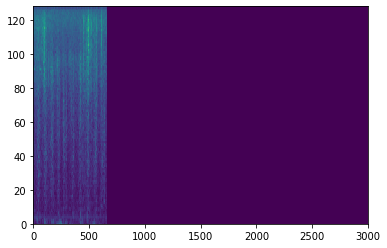

In [ ]:
# Typical spectrogram for "Walk_and_footsteps"
plt.pcolormesh(data[975,:,:])

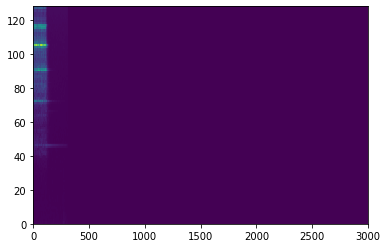

In [ ]:
# Typical spectrogram for "Doorbell"
plt.pcolormesh(data[843,:,:])

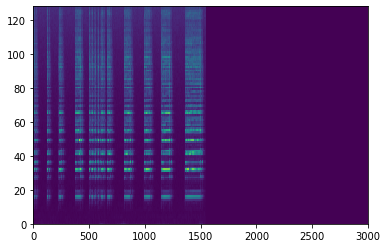

In [ ]:
# Typical spectrogram for "Vehicle_horn_and_car_horn_and_honking"
plt.pcolormesh(data[789,:,:])

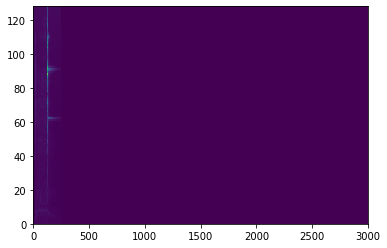

In [ ]:
# Typical spectrogram for "Microwave_oven"
plt.pcolormesh(data[675,:,:])

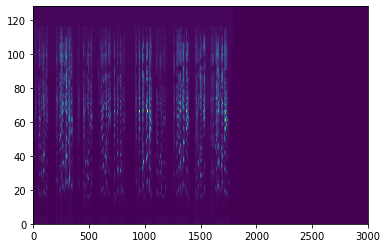

In [ ]:
# Typical spectrogram for "Crying_and_sobbing"
plt.pcolormesh(data[589,:,:])

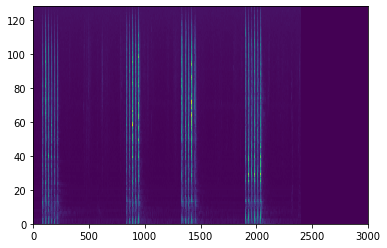

In [ ]:
# Typical spectrogram for "Knock"
plt.pcolormesh(data[457,:,:])

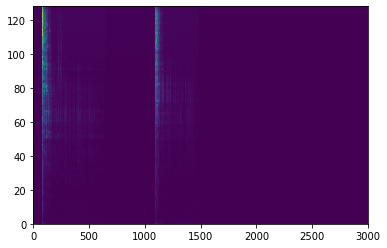

In [ ]:
# Typical spectrogram for "Shatter"
plt.pcolormesh(data[337,:,:])

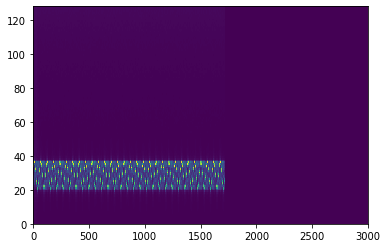

In [ ]:
# Typical spectrogram for "Siren"
plt.pcolormesh(data[270,:,:])

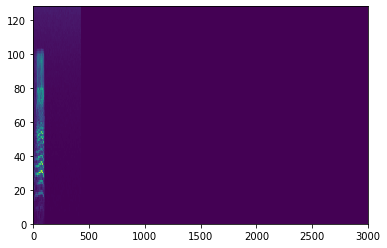

In [ ]:
# Typical spectrogram for "Meow"
plt.pcolormesh(data[199,:,:])

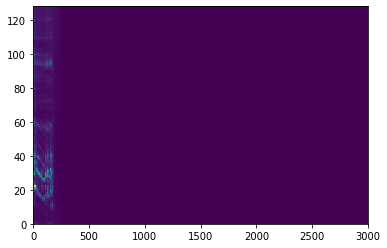

In [ ]:
# Typical spectrogram for "Bark"
plt.pcolormesh(data[84,:,:])

### Data Preprocessing

In [ ]:
# We constrain the signal length for each datapoint to the mean of the length 
mean_length=int(np.mean(length))
print(mean_length)

593


In [ ]:
# Splitting the data for training vs testing
from sklearn.utils import shuffle
data, labels, length = shuffle(data, labels, np.array(length))
train_data = data[:900, :, :]
train_labels = labels[:900]
train_length = length[:900]
test_data = data[900:, :, :]
test_labels = labels[900:]
test_length = length[900:]

In [ ]:
# Duplicate padding for samples smaller than mean_length
# For train_data
for i in range(900):
  # We define v that is the signal size of the i'th sample
  v = train_length[i]
  if v<mean_length:
    train_length[i]=mean_length
    while v<mean_length:
      train_data[i, :, v:v+train_length[i]] = train_data[i, :, 0:train_length[i]]
      v += train_length[i]
# For test_data
for i in range(100):
  # We define v that is the signal size of the i'th sample
  v = test_length[i]
  if v<mean_length:
    test_length[i]=mean_length
    while v<mean_length:
      test_data[i, :, v:v+test_length[i]] = test_data[i, :, 0:test_length[i]]
      v += test_length[i]

In [ ]:
train_data = train_data[:, :, :mean_length]
test_data = test_data[:, :, :mean_length]

In [ ]:
# Saving the matrices remotely
np.savez(loc + "main.npz", train_data = train_data, test_data = test_data, train_labels = train_labels, test_labels = test_labels)

# ML Models

In [ ]:
# Loading dataset
load_data = np.load(loc + "main.npz")
train_data = load_data['train_data']
test_data = load_data['test_data']
train_labels = load_data['train_labels']
test_labels = load_data['test_labels']
length = train_data.shape[-1]
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(900, 128, 593)
(100, 128, 593)
(900, 1)
(100, 1)


In [ ]:
# One-hot encoding for converting labels to vectors
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
# Shuffling the data
from sklearn.utils import shuffle
train_data, train_labels = shuffle(train_data, train_labels, random_state = 27)
test_data, test_labels = shuffle(test_data, test_labels, random_state = 27)

### Method 1: CNN Model

In [ ]:
# Dimension expansion for training with CNN
train_data = np.expand_dims(train_data, axis = 3)
test_data = np.expand_dims(test_data, axis = 3)

In [ ]:
# CNN Model
input_shape = (128, mean_length, 1)
inp = tf.keras.Input(shape = input_shape)

conv1 = layers.Conv2D(32, (5, 5), strides = (1, 1), padding = 'same')(inp)
pooling1 = layers.MaxPool2D(pool_size = (2, 2))(conv1)
conv2 = layers.Conv2D(16, (3, 3), strides = (1, 1), padding = 'same')(pooling1)
pooling2 = layers.MaxPool2D(pool_size = (2, 2))(conv2)
conv3 = layers.Conv2D(8, (3, 3), strides = (1, 1), padding = 'same')(pooling2)
pooling3 = layers.MaxPool2D(pool_size = (2, 2))(conv3)
flatten = layers.Flatten()(pooling3)
dense1 = layers.Dense(32, activation='relu')(flatten)
dropout1 = tf.keras.layers.Dropout(.1)(dense1)
dense2 = layers.Dense(32, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(.1)(dense2)
dense3 = layers.Dense(16, activation='relu')(dropout2)

out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(dense3)

cnn = tf.keras.Model(inputs = inp, outputs = out)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 593, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 593, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 296, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 296, 16)       4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 148, 16)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 148, 8)        1160  

In [ ]:
# Compiling the model
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=60,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)]
history = cnn.fit(train_data, train_labels, validation_data = (test_data, test_labels), epochs = 1000, batch_size = 50, callbacks = callbacks)

Epoch 1/1000
18/18 [==============================] - 12s 74ms/step - loss: 2.4317 - acc: 0.1389 - val_loss: 2.2386 - val_acc: 0.2100
Epoch 2/1000
18/18 [==============================] - 1s 61ms/step - loss: 2.1602 - acc: 0.2278 - val_loss: 2.1244 - val_acc: 0.2500
Epoch 3/1000
18/18 [==============================] - 1s 62ms/step - loss: 2.0552 - acc: 0.2789 - val_loss: 2.0636 - val_acc: 0.3300
Epoch 4/1000
18/18 [==============================] - 1s 62ms/step - loss: 1.9520 - acc: 0.3444 - val_loss: 1.9481 - val_acc: 0.3700
Epoch 5/1000
18/18 [==============================] - 1s 61ms/step - loss: 1.7927 - acc: 0.3778 - val_loss: 1.8255 - val_acc: 0.4000
Epoch 6/1000
18/18 [==============================] - 1s 61ms/step - loss: 1.6825 - acc: 0.4256 - val_loss: 1.6784 - val_acc: 0.5300
Epoch 7/1000
18/18 [==============================] - 1s 62ms/step - loss: 1.6482 - acc: 0.4578 - val_loss: 1.7496 - val_acc: 0.5100
Epoch 8/1000
18/18 [==============================] - 1s 61ms/step -

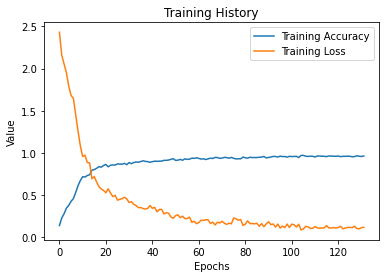

Training accuracy with preprocessing is:  0.9644444584846497
Training loss with preprocessing is:  0.11841923743486404


In [ ]:
# Plots
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('Epochs')
plt.show()
#print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Training accuracy with preprocessing is: ", history.history['acc'][-1])

#print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Training loss with preprocessing is: ", history.history['loss'][-1])

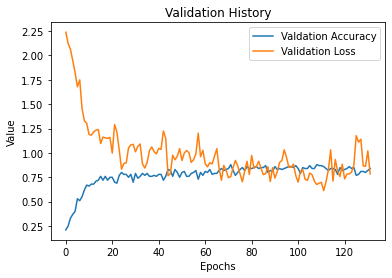

Best validation accuracy:  0.8799999952316284
Best validation loss:  0.7578352093696594


In [ ]:
# Plots
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('Epochs')
plt.show()
# print("Initial Validation accuracy: ", history.history['val_acc'][0])
print("Best validation accuracy: ", np.max(history.history['val_acc']))

# print("Initial Validation loss: ", history.history['val_loss'][0])
print("Best validation loss: ", history.history['val_loss'][np.argmax(history.history['val_acc'])])

In [ ]:
# Saving the model remotely
cnn.save('cnn')

### Method 2: Model with fully-connected layers (with pooling)

In [ ]:
# Fully-connected layers with pooling
from IPython.core.interactiveshell import InputRejected
input_shape = (128, mean_length, 1)
input = tf.keras.Input(shape = input_shape)

flatten = layers.Flatten()(input)
dense1 = layers.Dense(128, activation='relu')(flatten)
dropout1 = tf.keras.layers.Dropout(.1)(dense1)
dense2 = layers.Dense(64, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(.1)(dense2)
dense3 = layers.Dense(64, activation='relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(.1)(dense3)
dense4 = layers.Dense(32, activation='relu')(dropout3)

out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(dense4)

denseModel = tf.keras.Model(inputs = input, outputs = out)
print(denseModel.summary())

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
denseModel.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.01,
    patience=60,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)]
history = denseModel.fit(train_data, train_labels, validation_data = (test_data, test_labels), epochs = 1000, batch_size = 10, callbacks = callbacks)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 593, 1)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 75904)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               9715840   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160

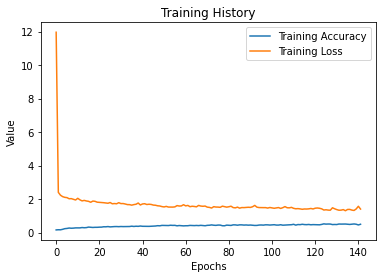

Training accuracy with preprocessing is:  0.4933333396911621
Training loss with preprocessing is:  1.4013094902038574


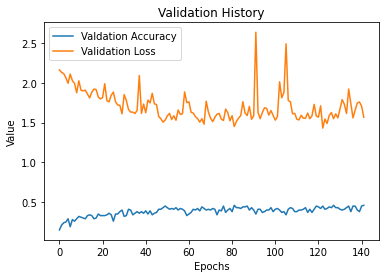

Best validation accuracy:  0.46000000834465027
Best validation loss:  1.451169490814209


In [ ]:
# Plots
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('Epochs')
plt.show()
#print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Training accuracy with preprocessing is: ", history.history['acc'][-1])

#print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Training loss with preprocessing is: ", history.history['loss'][-1])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('Epochs')
plt.show()
# print("Initial Validation accuracy: ", history.history['val_acc'][0])
print("Best validation accuracy: ", np.max(history.history['val_acc']))

# print("Initial Validation loss: ", history.history['val_loss'][0])
print("Best validation loss: ", history.history['val_loss'][np.argmax(history.history['val_acc'])])

## Results:
### Accuracy with CNN model: 88% 
### Accuracy with model with fully-connected layers: 46%